# Instacart Data Exploration 

__Problem Description:__
Whether you shop from meticulously planned grocery lists or let whimsy guide your grazing, our unique food rituals define who we are. Instacart, a grocery ordering and delivery app, aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.

Instacart’s data science team plays a big part in providing this delightful shopping experience. Currently they use transactional data to develop models that predict which products a user will buy again, try for the first time, or add to their cart next during a session. Recently, Instacart open sourced this data - see their blog post on 3 Million Instacart Orders, Open Sourced.

In this competition, Instacart is challenging the Kaggle community to use this anonymized data on customer orders over time __to predict which previously purchased products will be in a user’s next order.__ They’re not only looking for the best model, Instacart’s also looking for machine learning engineers to grow their team.

__File descriptions:__

Each entity (customer, product, order, aisle, etc.) has an associated unique id. Most of the files and variable names should be self-explanatory.

* __aisles.csv__

 aisle_id,aisle  
 1,prepared soups salads  
 2,specialty cheeses  
 3,energy granola bars  
 ...

* __departments.csv__

 department_id,department  
 1,frozen  
 2,other  
 3,bakery  
 ...

* __order\_products_*.csv__

 These files specify which products were purchased in each order. order_products_prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items. See the evaluation page for full details.

 order_id,product_id,add_to_cart_order,reordered  
 1,49302,1,1  
 1,11109,2,1  
 1,10246,3,0  
 ... 

* __orders.csv__

 This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

 order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order  
 2539329,1,prior,1,2,08,  
 2398795,1,prior,2,3,07,15.0  
 473747,1,prior,3,3,12,21.0  
 ...

* __products.csv__

 product_id,product_name,aisle_id,department_id
 1,Chocolate Sandwich Cookies,61,19  
 2,All-Seasons Salt,104,13  
 3,Robust Golden Unsweetened Oolong Tea,94,7  
 ...

* __sample\_submission.csv__

 order_id,products
 17,39276  
 34,39276  
 137,39276  
 ...

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

from sklearn import (
    tree,
    metrics,
    linear_model,
    ensemble,
    neighbors)

from sklearn.neighbors import KNeighborsClassifier
import re
import os
import gc

%matplotlib inline

## Initializing Data Directories and Data Filenames.

### Location of the dataset, which will be used to build the dataframes

In [22]:
ddir = 'Instacart Data'
print os.path.abspath(ddir)

/Users/NewAdmin/Documents/Anwar/DS Class/DS Final Project/Instacart Data


### List of the files to be used

In [23]:
aisles = ('aisles.csv')
depts = ('departments.csv')
ordprodprior = ('order_products__prior.csv')
ordprodtrain = ('order_products__train.csv')
orders = ('orders.csv')
products = ('products.csv')
sample_submission = ('sample_submission.csv')

### All Necessary Functions

In [24]:
#-------------------------------------
# buildDataFrame()
#-------------------------------------
def buildDataFrame(sFilename = ""):
    print 'Loading ', sFilename
    df = pd.read_csv(os.path.join(ddir, sFilename))
    print 'Total Rows:', df.shape[0]
    return df

#-------------------------------------
# normalizeData()
#-------------------------------------
def normalizeData(pdseries):
    mu = pdseries.mean()
    std = pdseries.std()
    return pdseries.map(lambda x: (x-mu)/std)


#-------------------------------------
# loadUpProducts()
#-------------------------------------
def loadUpProducts():
    print "Preparing up ", aisles
    df_aisles = buildDataFrame(aisles)

    print "Preparing up ", depts
    df_depts = buildDataFrame(depts)
    
    
    print "Preparing up ", products
    df_products = buildDataFrame(products)

    print "Aggregating based on product based on Prior"
    #df_xx = buildDataFrame(ordprodprior)
    #df_xx = df_xx.groupby('product_id').agg({'order_id':"nunique", 'add_to_cart_order':"median", 'reordered':"sum"})
    
    #df_xx.columns = ['nunique_order_id', 'median_add_to_cart_order', 'sum_reordered']
    
    # normalize
    #df_xx['nunique_order_id'] = normalizeData(df_xx['nunique_order_id'])
    #df_xx['sum_reordered'] = normalizeData(df_xx['sum_reordered'])
    
    #df_xx['reordered_ratio'] = df_xx['nunique_order_id']*df_xx['sum_reordered']
    #df_xx['reordered_ratio'] = normalizeData(df_xx['reordered_ratio'])
    
    #df_xx.sort_values(['reordered_ratio'] ,ascending=False, inplace=True)
    #df_xx.reset_index(inplace=True)
    #df_xx.head(25)


    df_products = pd.merge(df_products, df_depts, on='department_id')
    df_products = pd.merge(df_products, df_aisles, on ='aisle_id')
    #df_products = pd.merge(df_products, df_xx, on='product_id')
    
    df_orders = loadUpOrders()
    #df_orders.head()# user_id: 26086,1868,5296  max_orders:99

    df_orders_prior = buildDataFrame(ordprodprior)
    #df_orders_prior.head()

    df_orders = pd.merge(df_orders_prior, df_orders, on='order_id')
    #df_orders.head()

    df_prod_agg = pd.DataFrame(df_orders.groupby('product_id').agg({"user_id":'nunique', 'order_id':"nunique", 'add_to_cart_order':"median", 'reordered':"sum"}))
    df_prod_agg.reset_index(inplace=True)
    df_prod_agg.columns = ['product_id', 'nunique_user_id', 'nunique_order_id', 'median_add_to_cart_order', 'sum_reordered']

    df_products = pd.merge(df_products, df_prod_agg, on='product_id')
    
    # df_products = pd.get_dummies(df_products, prefix='dept', prefix_sep='_', dummy_na=False, columns=['department'], sparse=False, drop_first=True) 
    
    df_products.drop(['aisle_id', 'department_id', 'department', 'aisle'], axis=1, inplace=True)
    
    df_products['nunique_user_id'] = normalizeData(df_products['nunique_user_id'])
    df_products['nunique_order_id'] = normalizeData(df_products['nunique_order_id'])
    df_products['median_add_to_cart_order'] = normalizeData(df_products['median_add_to_cart_order'])
    df_products['sum_reordered'] = normalizeData(df_products['sum_reordered'])
    
    #garbage collection
    #del df_xx
    del df_aisles
    del df_depts
    del df_orders
    del df_orders_prior
    del df_prod_agg

    
    print df_products.shape[0], 'Product Rows'
    
    #df_products.set_index('product_id', inplace=True)
    return df_products

#-------------------------------------
# sliceTrainEvalSet()
#-------------------------------------
def sliceTrainEvalSet(df):
    useridlist = df.user_id.unique()
    
    for userid in useridlist:
        idx = df[ (df.user_id == userid) ].index[-1]
        #print idx
        df['eval_set'].loc[idx] = 'train'
        #print df.loc[idx]
    
    return df

#-------------------------------------
# calibrate_days_since_prior_order()
#-------------------------------------
def calibrate_days_since_prior_order(df):
    userlist = df.user_id.unique().tolist()
    # create first order out of day since prior order
    df['not_first_order'] = (df['days_since_prior_order'] != 0).astype('int') * 100
    
    for user in userlist:
        maxdays_since_prior_order = df[ df.user_id == user ].days_since_prior_order.max()
        df['day_freq'] = (maxdays_since_prior_order - df.days_since_prior_order) * df['not_first_order']
    return df

#-------------------------------------
# calibrate_order_dow()
#-------------------------------------
def calibrate_order_dow(df):
    df['order_dow'] = df['order_dow'].apply(lambda x: 7 if x == 0 else x)
    
    l_dow = df_orders.groupby('order_dow').order_id.count().sort_values(ascending=False).index.tolist()
    l_dow.reverse()

    d = {}
    for i in range(1,len(l_dow)+1): 
        data = l_dow[i-1]
        d[data] = i * 100

    df_orders['order_dow_freq'] = df_orders['order_dow'].apply(lambda x: d[x])

    return df

#-------------------------------------
# calibrate_order_hour_of_day()
#-------------------------------------
def calibrate_order_hour_of_day(df):
    
    l_dow = df_orders.groupby('order_hour_of_day').order_id.count().sort_values(ascending=False).index.tolist()
    l_dow.reverse()

    d = {}
    for i in range(1,len(l_dow)+1): 
        data = l_dow[i-1]
        d[data] = i * 100

    df_orders['order_hour_of_day_freq'] = df_orders['order_hour_of_day'].apply(lambda x: d[x])

    return df

#-------------------------------------
# loadUpOrders()
#-------------------------------------
def loadUpOrders():
    df_orders = buildDataFrame(orders)
    
    # remove all test eval set
    df_orders.drop(df_orders.index[ df_orders['eval_set'] == 'test'], inplace=True)
    
    # replace all train with test
    df_orders['eval_set'].apply(lambda x: 'test' if x == 'train' else x)
    
    # max order_number from every order will become 'train
    
    
    print "Total Orders: ", df_orders.shape[0]
    df_orders['days_since_prior_order'].fillna(value=0, inplace=True)
    
    return df_orders


#-------------------------------------
# normalizeData()
#-------------------------------------
def normalizeData(pdseries):
    mu = pdseries.mean()
    std = pdseries.std()
    return pdseries.map(lambda x: (x-mu)/std)
    

#-------------------------------------
# calibrateOrders()
#-------------------------------------
def calibrateOrders(df_orders):
    
    # calibrate days since prior order
    df_orders = calibrate_days_since_prior_order(df_orders)
    
    # calibrate order dow
    df_orders = calibrate_order_dow(df_orders)
    
    #calibrate order_hour_of_the_day
    df_orders = calibrate_order_hour_of_day(df_orders)
    
    df_orders['order_score'] = df_orders['not_first_order'] + df_orders['day_freq'] + df_orders['order_dow_freq'] + df_orders['order_hour_of_day_freq']

    #normalizer = preprocessing.Normalizer()
    #df_orders['order_score'] = normalizer.fit_transform( df_orders[['order_score']] )
    df_orders['order_score'] = normalizeData(df_orders['order_score'])
    
    return df_orders




"""    if df_orders == None or user_id == None or eval_set == None:
        print -------------------------------------------
            Parameter missing or incorrect parameters"
            -------------------------------------------
            df_orders: data frame of the entire orders
            user_ids: list of user_id from the df_orders
            eval_set: either 'prior' or 'train'

            returns dataframe complete orders+orders_product_[train/prior]+products
            -------------------------------------------
        """
#-------------------------------------
# createExtendedDataset()
#-------------------------------------
def createExtendedDataset(df_orders, user_ids, eval_set):
    
    # filter only the users we need
    df_orders = df_orders[ df_orders['user_id'].isin( user_ids )]
    print 'Orders filtered for user_ids: ', df_orders.shape[0]

    #slice up only the specific eval set we need.
    df_orders_eval = df_orders[ df_orders['eval_set'] == eval_set]
    print 'Orders filtered for user_ids + eval set: ', df_orders_eval.shape[0]

    # load up orders_product_[eval set]
    file = lambda x: ordprodtrain if eval_set == 'test' else ordprodprior
    print 'Order Product Details file to be loaded:', file(eval_set)
    
    df_orders_product_evalset  = buildDataFrame(file(eval_set))
    
    df_orders_product_evalset = pd.merge(df_orders_eval, df_orders_product_evalset, on='order_id')
    df_orders_product_evalset = pd.merge(df_orders_product_evalset, df_products, on='product_id')
    print "After merging the orders_eval and order_products_eval, Total Records: ", df_orders_product_evalset.shape[0]
    
    print "*** Done ***"
    return df_orders_product_evalset


#-------------------------------------
# createFeatures()
#-------------------------------------
def createFeatures(df):
    df['first_order'] = df['days_since_prior_order'].map(lambda x: 1 if x == 0.0 else 0)


    df = pd.DataFrame(df.groupby(['product_id', 'reordered']).agg({'order_dow': 'median', 
                                                                   'order_hour_of_day': 'median',
                                                                   'days_since_prior_order': 'mean',
                                                                   'first_order': 'median',
                                                                   'user_id':'nunique', 
                                                                   'order_id':'nunique'}))
    
    colList = ['count_user_id', 
               'count_order_id', 
               'median_first_order', 
               'mean_days_since_prior_order', 
               'median_order_hour_of_day', 
               'median_order_dow']

    df.columns = colList

    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()
    normalizer = preprocessing.Normalizer()

    
    # Min max normalize all feature column
    for col in colList:
        df[col] = normalizer.fit_transform( df[[col]] )

    # Calculate & normalize Weight
    df['weight'] = (df['count_user_id'] + 
                    df['count_order_id'] + 0 )
                    #df['median_first_order_norm'] + 
                    #df['mean_days_since_prior_order_norm'] + 
                    #df['median_order_hour_of_day_norm'] + 
                    #df['median_order_dow_norm'] )
    
    df['weight'] = min_max_scaler.fit_transform( df[['weight']] )

    df.sort_values('weight', ascending=False, inplace=True)
    df.reset_index(inplace=True)
    df_products.reset_index(inplace=True)
    df = pd.merge(df, df_products) 
    df_products.set_index('product_id', inplace=True)

    return df

## Building Dataframes from the file paths.

### Build Product DF
as needed

In [25]:
# Understanding Products
df_products_asis = buildDataFrame(products)
df_depts_asis = buildDataFrame(depts)
df_aisles_asis = buildDataFrame(aisles)
df_orders_asis = buildDataFrame(orders)
df_orders_prior_asis = buildDataFrame(ordprodprior)

Loading  products.csv
Total Rows: 49688
Loading  departments.csv
Total Rows: 21
Loading  aisles.csv
Total Rows: 134
Loading  orders.csv
Total Rows: 3421083
Loading  order_products__prior.csv
Total Rows: 32434489


In [26]:

df_products_asis = pd.merge(df_products_asis, df_depts_asis, on='department_id')
df_products_asis = pd.merge(df_products_asis, df_aisles_asis, on='aisle_id')
df_products_asis.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes


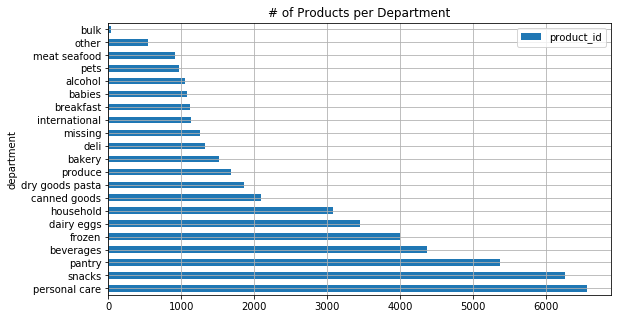

In [39]:
df_products_asis_grp = pd.DataFrame( df_products_asis.groupby('department').product_id.count())
df_products_asis_grp.sort_values('product_id', ascending=False, inplace=True)
df_products_asis_grp.plot(kind='barh', figsize=(9,5), title='# of Products per Department', grid=True, fontsize=10)

In [28]:
df_orders_asis.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


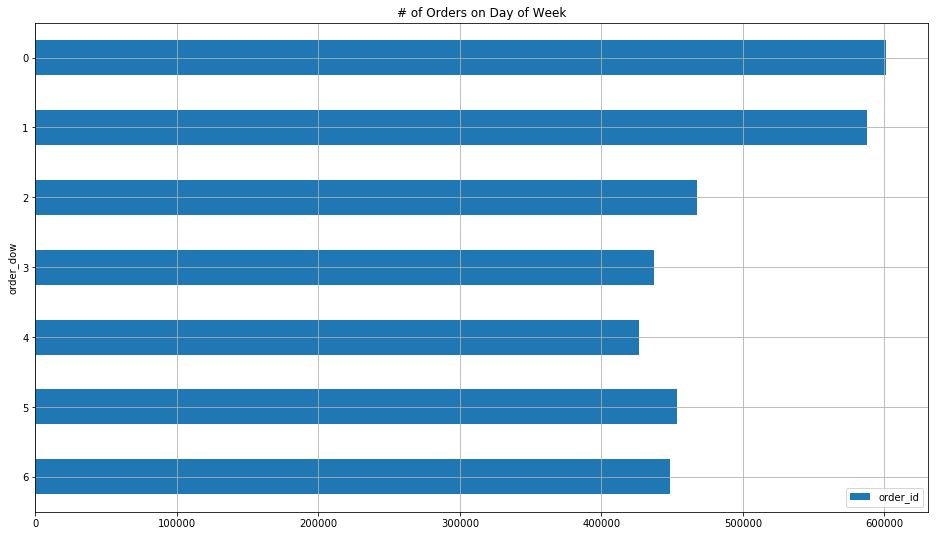

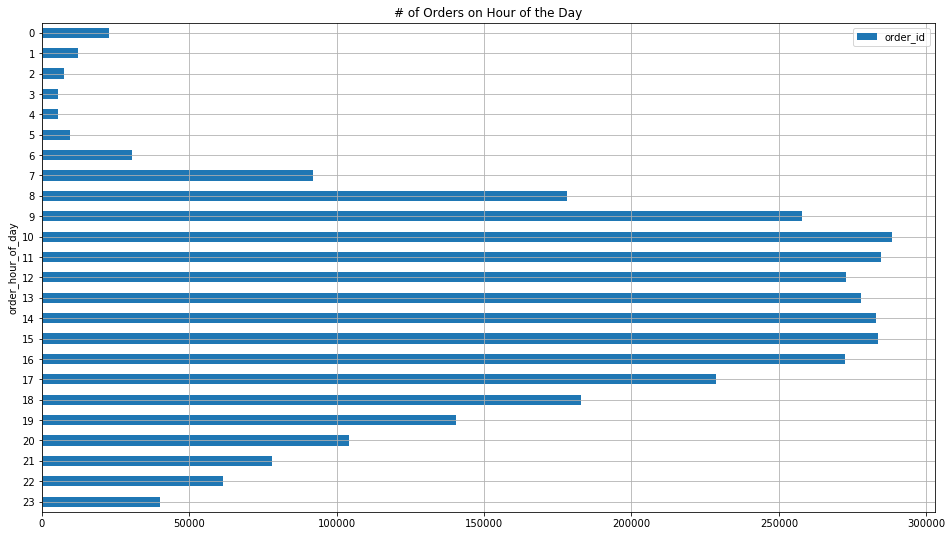

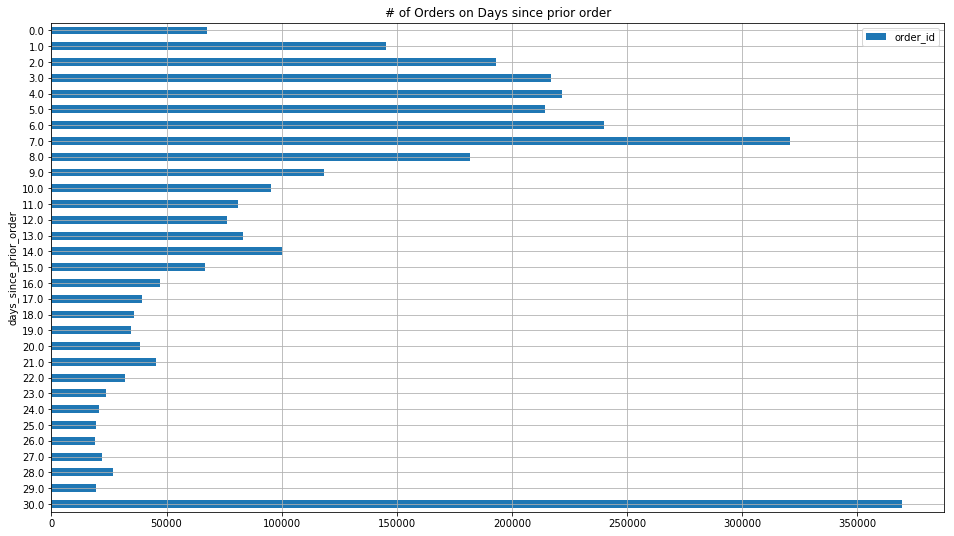

In [41]:
df_orders_asis_grp = pd.DataFrame( df_orders_asis.groupby('order_dow').order_id.count() ).reset_index()
df_orders_asis_grp.sort_values('order_dow', ascending=False, inplace=True)
df_orders_asis_grp.plot(kind = 'barh',x='order_dow', y='order_id', figsize=(16,9), title='# of Orders on Day of Week', grid=True, fontsize=10)

df_orders_asis_grp = pd.DataFrame(df_orders_asis.groupby('order_hour_of_day').order_id.count()).reset_index()
df_orders_asis_grp.sort_values('order_hour_of_day', ascending=False, inplace=True)
df_orders_asis_grp.plot(kind = 'barh',x='order_hour_of_day', y='order_id', figsize=(16,9), title='# of Orders on Hour of the Day', grid=True, fontsize=10)

df_orders_asis_grp = pd.DataFrame(df_orders_asis.groupby('days_since_prior_order').order_id.count()).reset_index()
df_orders_asis_grp.sort_values('days_since_prior_order', ascending=False, inplace=True)
df_orders_asis_grp.plot(kind = 'barh',x='days_since_prior_order', y='order_id', figsize=(16,9), title='# of Orders on Days since prior order', grid=True, fontsize=10)


   order_hour_of_day  order_dow  order_id
0                0.0        0.0      3936
1                0.0        1.0      3674
2                0.0        2.0      3059
3                0.0        3.0      2952
4                0.0        4.0      2642


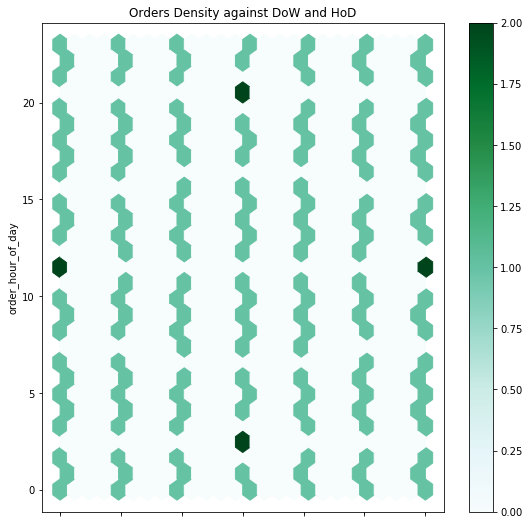

In [56]:
df_orders_asis_grp = pd.DataFrame(df_orders_asis.groupby(['order_hour_of_day','order_dow']).order_id.nunique()).reset_index()
df_orders_asis_grp.order_hour_of_day = df_orders_asis_grp.order_hour_of_day.astype(float)
df_orders_asis_grp.order_dow = df_orders_asis_grp.order_dow.astype(float)
#df_orders_asis_grp.order_hour_of_day.apply(normalizeData)
#df_orders_asis_grp.order_dow.apply(normalizeData)
print df_orders_asis_grp.head()
df_orders_asis_grp.sort_values('order_id', ascending=False, inplace=True)
df_orders_asis_grp.plot(kind = 'hexbin',y='order_hour_of_day', x='order_dow', figsize=(9,9), gridsize=25, title='Orders Density against DoW and HoD')



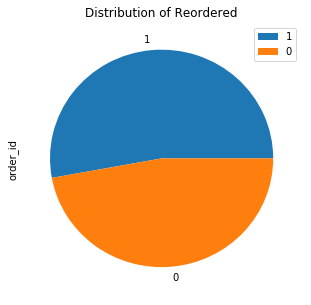

In [42]:
df_orders_asis_grp = pd.DataFrame(df_orders_prior_asis.groupby('reordered').order_id.nunique()).reset_index()
df_orders_asis_grp.sort_values('order_id', ascending=False, inplace=True)
df_orders_asis_grp.plot(kind='pie', y='order_id', figsize=(5,5), title='Distribution of Reordered', grid=True, fontsize=10)

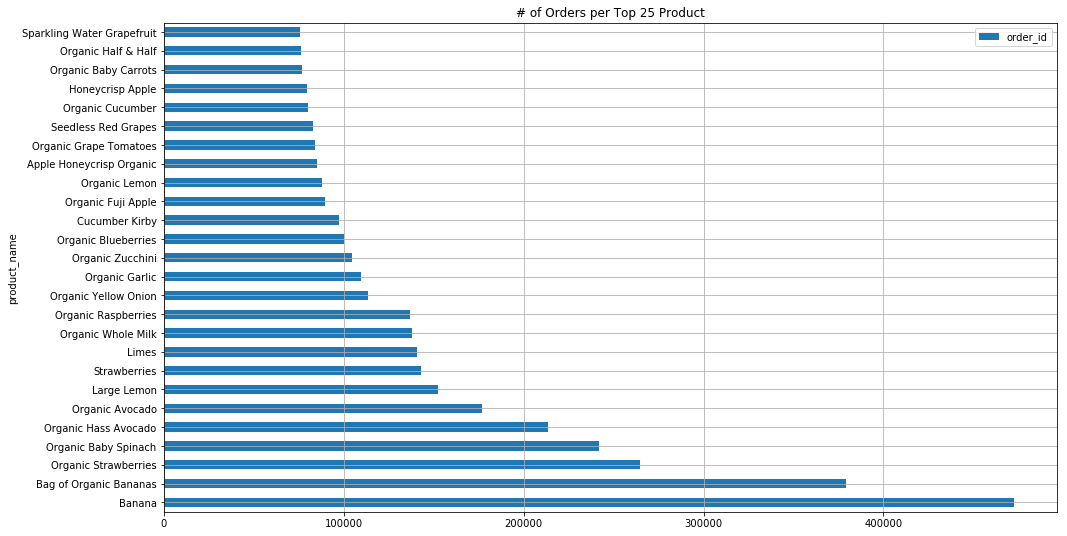

In [43]:
df_orders_asis_grp = pd.DataFrame(df_orders_prior_asis.groupby('product_id').order_id.nunique()).reset_index()
df_orders_asis_grp.sort_values('order_id', ascending=False, inplace=True)
df_orders_asis_grp.reset_index(inplace=True)
df_orders_asis_grp = df_orders_asis_grp.loc[:25]
df_orders_asis_grp = pd.merge(df_orders_asis_grp, df_products_asis, on='product_id')
df_orders_asis_grp.plot(kind = 'barh', x='product_name', y='order_id', figsize=(16,9), title='# of Orders per Top 25 Product', grid=True, fontsize=10)

In [72]:

df_products = loadUpProducts()
df_products.head()

Preparing up  aisles.csv
Loading  aisles.csv
Total Rows: 134
Preparing up  departments.csv
Loading  departments.csv
Total Rows: 21
Preparing up  products.csv
Loading  products.csv
Total Rows: 49688
Aggregating based on product based on Prior
Loading  orders.csv
Total Rows: 3421083
Total Orders:  3346083
Loading  order_products__prior.csv
Total Rows: 32434489
49677 Product Rows


,product_id,product_name,nunique_user_id,nunique_order_id,median_add_to_cart_order,sum_reordered
0,1,Chocolate Sandwich Cookies,0.250222,-1.225281,0.342386,0.208507
1,78,Nutter Butter Cookie Bites Go-Pak,-0.133951,2.160282,-0.198573,-0.106066
2,102,Danish Butter Cookies,-0.097641,-1.225281,-0.090075,-0.097181
3,172,Gluten Free All Natural Chocolate Chip Cookies,-0.116005,-1.601455,-0.184819,-0.087186
4,285,Mini Nilla Wafers Munch Pack,-0.103693,0.467500,-0.128279,-0.091350


In [73]:
df_products.sort_values('nunique_order_id', ascending=False, inplace=True)
df_products.to_csv('products_aggregation.csv')
df_products.head(25)

,product_id,product_name,nunique_user_id,nunique_order_id,median_add_to_cart_order,sum_reordered
46837,20223,Citronge Extra Fine Orange Liqueur,-0.136038,17.207228,-0.203921,-0.106899
1694,43778,Strawberry Energy Gel,-0.136038,16.078707,-0.203921,-0.106899
18495,22747,Vanilla Bean Sheep Milk Ice Cream,-0.136038,14.574012,-0.203921,-0.106899
24180,33406,Eczema Control,-0.135829,12.693144,-0.203157,-0.106899
11605,45872,Jalapeno Babies,-0.135620,11.564623,-0.202393,-0.106899
11194,45319,Original Submarine Dressing,-0.134994,10.624189,-0.200865,-0.106621
44235,13397,"Molasses, Bead",-0.136038,10.059929,-0.203921,-0.106899
4787,24280,Natural Blueberries Covered In Dark Chocolate,-0.134577,9.871842,-0.202393,-0.105510
40783,37014,Sloppy Joe Sandwich Makers,-0.136038,9.683755,-0.203921,-0.106899
3142,23653,Aged Parmesan Cheese Sticks,-0.136038,9.683755,-0.203921,-0.106899


## Preparing Features

In [74]:
features = [col for col in df_products.columns.tolist() if col.find('product_') == -1] # all features except "product_name and product_id
target =  'product_id'

X = df_products[features]
y = df_products[target]

#print X
print y

46837    20223
1694     43778
18495    22747
24180    33406
11605    45872
11194    45319
44235    13397
4787     24280
40783    37014
3142     23653
13218    42687
43774    38977
13716     3832
12757    14549
43622    33183
37955     4170
33940    45732
40898     4424
17321    37231
41095    45291
738      42031
20524     7534
36498    10584
42932     5643
33454    11861
27442    43388
23965    43098
24198    37005
24533     9386
29277     9305
         ...  
43914    44081
46525     2216
47275    40594
30428    33062
47121    21287
43159    14208
3984     20598
21094     4901
48658    10042
37105    16506
49591    46404
43170    14546
49258    16161
4609     17686
35456     2769
21813    38131
21803    37589
24117    21306
47395     9711
46876    29347
5041     34463
49471    35133
30456    37902
14637      916
20244    27813
47153    25143
43723    37088
25812    19576
33971    47765
21228    10572
Name: product_id, Length: 49677, dtype: int64


In [75]:
from sklearn.model_selection import cross_val_score
from sklearn import (
    metrics, 
    linear_model, 
    ensemble,
    neighbors,
)

cls = neighbors.KNeighborsClassifier(n_neighbors=5)
cls

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [76]:
cls.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [78]:
cv = cross_val_score(cls, X, y, scoring='roc_auc', cv=2)#.mean()
print 'KNN:', cv

ValueError: n_splits=2 cannot be greater than the number of members in each class.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(cv)
plt.show()
bottom = pd.Series(cv).quantile(0.025)
top = pd.Series(cv).quantile(.9725)

print 'Confidence Range:',(bottom, top)

In [ ]:
# 20223 = [46180 46666 45448 46152 45758]
# 45872 = [44350 46371 45437 45947 45085]
df_orders = buildDataFrame(ordprodprior)
df_orders.head()


In [ ]:
prod_id = 5643

test1 = df_products[features].loc[prod_id].tolist()
print test1

print cls.predict([test1])

results = cls.kneighbors(X=[test1], n_neighbors=5, return_distance=True)
print results


print df_products[df_products.product_id.isin(results[1][0])][['product_id', 'product_name']]

In [ ]:
ordlist = df_orders[ df_orders.product_id == prod_id]['order_id'].tolist()

In [ ]:
prodlist = df_orders[ df_orders.order_id.isin(ordlist)]['product_id'].tolist()
prodlist.sort()
print prodlist

In [ ]:
df_orders[ df_orders.product_id.isin(results[1][0])]['order_id'].tolist()

In [ ]:
#-----------------------------------------------------------------------------------------------------

In [ ]:
df_orders = loadUpOrders()

In [ ]:
df_orders[df_orders.eval_set == 'train']['user_id'].tolist()

In [ ]:
userList = [1566]
df_orders = df_orders[df_orders.user_id.isin(userList)]
df_orders.head()

In [ ]:
df_orders_p = df_orders[df_orders.eval_set == 'prior']
df_orders_t = df_orders[df_orders.eval_set == 'train']
df_orders_t.head()

In [ ]:
df_order_prior = buildDataFrame(ordprodprior)
df_order_prior = pd.merge(df_orders_p, df_order_prior, on='order_id')
df_order_prior.head()

In [ ]:
df_order_train = buildDataFrame(ordprodtrain)
df_order_train = pd.merge(df_orders_t, df_order_train, on='order_id')
df_order_train.head()

In [ ]:
train_product_list = df_order_train.product_id.tolist()
train_product_list

In [ ]:
df_order_prior[ ~(df_order_prior.product_id.isin(train_product_list)) ]